# Proyecto de producción

### Descripción del proyecto

Proyecto:

 - Cliente: planta/complejo siderúrgico.

Objetivo:

 - Objetivo del cliente: reducir el consumo de electricidad en la etapa de tratamiento del acero. Para ello, la planta necesita controlar la temperatura de la aleación.

 - Tarea del proyecto: construir un modelo que pronostique la temperatura de la aleación. El modelo desarrollado se utilizará para la simulación del proceso tecnológico. Permitirá reducir los costos de electricidad, mantenimiento y reparación.

Los datos se presentan en 7 archivos:

 - data_arc_new.csv — datos sobre los electrodos;

 - data_bulk_new.csv — datos de la alimentación de materiales a granel (volumen);

 - data_bulk_time_new.csv — datos de la alimentación de materiales a granel (tiempo);

 - data_gas_new.csv — datos del soplado/purga de la aleación con gas;

 - data_temp_new.csv — resultados de las mediciones de temperatura;

 - data_wire_new.csv — datos de materiales en alambre (volumen);

 - data_wire_time_new.csv — datos de materiales en alambre (tiempo).

Información adicional:

 - Variable objetivo: la última medición de temperatura del lote.

 - En un lote hay varias iteraciones de calentamiento (ciclos completos).

 - Métrica objetivo: MAE (MAE ≤ 6.8).

 - random_state = 91224.

Solicitudes adicionales del cliente:

 - Información sobre valores atípicos (potencia reactiva negativa, temperatura de fusión del acero < 1500).

 - Calcular e interpretar R² para el mejor modelo en el conjunto de prueba.

 - Realizar un análisis de importancia de variables del mejor modelo.

### Carga de datos

In [1]:
!pip install phik shap matplotlib seaborn --upgrade 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)
from phik.report import plot_correlation_matrix
from phik import report
import shap
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [3]:
data_arc_new=pd.read_csv('', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])

In [4]:
data_bulk_new=pd.read_csv('')

In [5]:
data_bulk_time_new=pd.read_csv('')

In [6]:
data_gas_new=pd.read_csv('')

In [7]:
data_temp_new=pd.read_csv('', parse_dates=['Время замера'])

In [8]:
data_wire_new=pd.read_csv('')

In [9]:
data_wire_time_new=pd.read_csv('', parse_dates=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'])

### Análisis exploratorio de cada archivo

Se realizó un análisis exploratorio de cada archivo y se extrajeron conclusiones sobre las características (features) disponibles.

##### Investigación del archivo data_arc_new

In [10]:
# Datos sobre los electrodos 
data_arc_new.info()
display(data_arc_new.describe())
display(data_arc_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
max     3241.000000           1.463773             1.270284

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

In [11]:
# Se identificó la anomalía mencionada por el cliente. Es un caso aislado.
data_arc_new[data_arc_new['Реактивная мощность']<=0]

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-28 02:22:08 2019-07-28 02:23:57           0.705344   

      Реактивная мощность  
9780          -715.479924

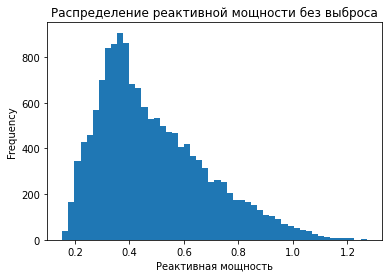

In [12]:
# Así se verá la distribución de los datos sin la anomalía, la cual será eliminada en la sección de preprocesamiento de datos. 
gr1=data_arc_new[data_arc_new['Реактивная мощность']>=0]['Реактивная мощность'].plot(kind='hist', bins=50, title='Распределение реактивной мощности без выброса')
gr1.set_xlabel('Реактивная мощность');

Conclusiones sobre data_arc_new:
- No hay valores faltantes.
- Начало нагрева дугой и Конец нагрева дугой (el inicio y fin del calentamiento por arco) están cargados en formato datetime64.
- Реактивная мощность (La potencia reactiva) - presenta un único valor atípico de producción.
<br/><br/>
- key — número de lote;
- Начало нагрева дугой — hora de inicio del calentamiento;
- Конец нагрева дугой — hora de finalización del calentamiento;
- Активная мощность — valor de la potencia activa;
- Реактивная мощность — valor de la potencia reactiva.

##### Investigación del archivo data_bulk_new

In [13]:
# Datos sobre la alimentación de materiales a granel (volumen)
data_bulk_new.info()
display(data_bulk_new.describe())
display(data_bulk_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [14]:
# Existen muchos valores faltantes, que serán completados más adelante.  
# Análisis de las variables con mayor cantidad de datos disponibles.
(3129-(data_bulk_new.isna().sum())).sort_values(ascending=False)

key        3129
Bulk 14    2806
Bulk 12    2450
Bulk 15    2248
Bulk 3     1298
Bulk 4     1014
Bulk 6      576
Bulk 1      252
Bulk 11     177
Bulk 10     176
Bulk 5       77
Bulk 7       25
Bulk 2       22
Bulk 9       19
Bulk 13      18
Bulk 8        1
dtype: int64

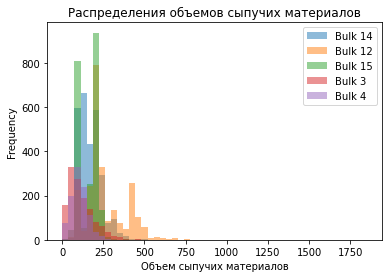

In [15]:
# Distribuciones de los volúmenes de materiales a granel más frecuentes EN UN SOLO GRÁFICO
list_bulk=['Bulk 14', 'Bulk 12', 'Bulk 15', 'Bulk 3', 'Bulk 4']
gr2=data_bulk_new[list_bulk].plot(kind='hist', bins=50, alpha=0.5, title='Распределения объемов сыпучих материалов')
gr2.set_xlabel('Объем сыпучих материалов');

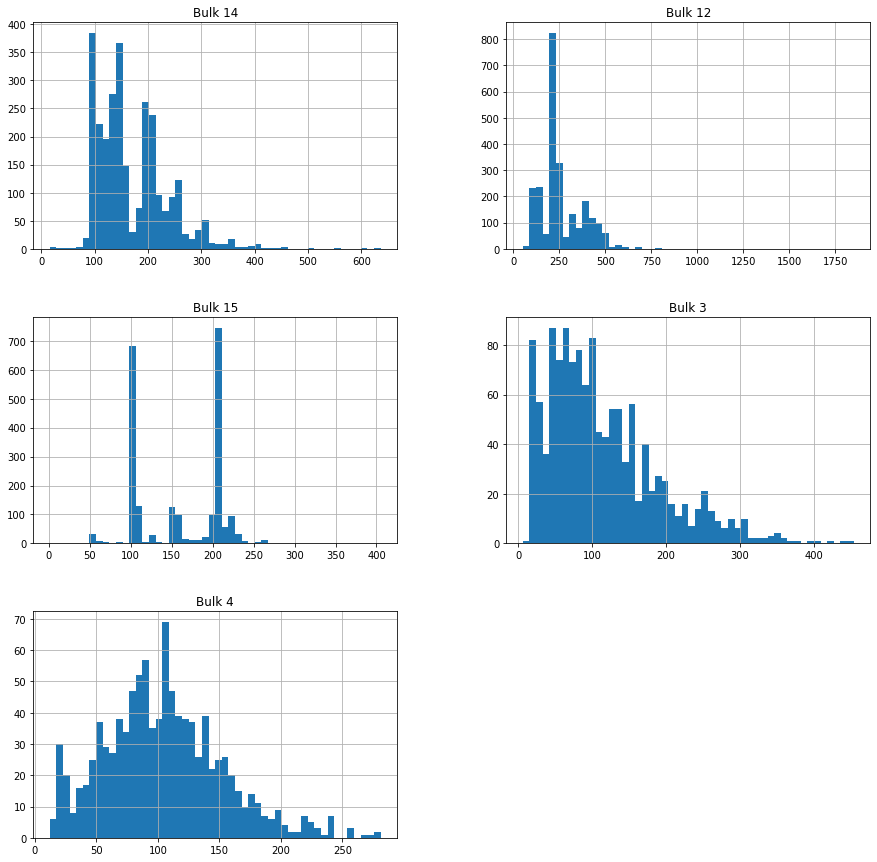

In [16]:
# Distribuciones de los volúmenes de materiales a granel más frecuentes EN GRÁFICOS SEPARADOS
data_bulk_new[list_bulk].hist(bins=50, figsize=(15, 15));

Conclusiones sobre data_bulk_new:

 - Hay muchos valores faltantes para diferentes materiales.

 - Los valores faltantes se llenarán con ceros, ya que se asume que el material simplemente no se añadió a la cuchara.

 - Las variables 14, 12, 15, 3 y 4 están mejor registradas que las demás. Sus distribuciones, en general, se encuentran en el mismo rango. No se observan valores atípicos evidentes; las distribuciones están sesgadas hacia valores menores y corresponden a distribuciones lognormales. La variable Bulk12 presenta dos máximos locales.
<br/><br/>
- key — número de lote;
- Bulk 1 … Bulk 15 — volumen del material añadido.

##### Investigación del archivo data_bulk_time_new.csv

In [17]:
# Datos sobre la alimentación de materiales a granel (tiempo) 
data_bulk_time_new.info()
display(data_bulk_time_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

In [18]:
# Análisis de las variables con mayor cantidad de datos disponibles  
# El mismo tipo de imputación que en data_bulk_new  
(3129-(data_bulk_time_new.isna().sum())).sort_values(ascending=False)

key        3129
Bulk 14    2806
Bulk 12    2450
Bulk 15    2248
Bulk 3     1298
Bulk 4     1014
Bulk 6      576
Bulk 1      252
Bulk 11     177
Bulk 10     176
Bulk 5       77
Bulk 7       25
Bulk 2       22
Bulk 9       19
Bulk 13      18
Bulk 8        1
dtype: int64

Conclusiones sobre data_bulk_time_new:

 - key — número de lote;

 - Bulk 1 … Bulk 15 — tiempo de alimentación del material.
<br/><br/>
 - El archivo sobre el tiempo de alimentación de materiales no se incluirá en la tabla final; se utiliza únicamente para verificar la coherencia de los datos.

 - Los datos están mejor registrados para las mismas variables: Bulk 14, Bulk 12, Bulk 15, Bulk 3 y Bulk 4.

#####  Investigación del archivo data_gas_new.csv

In [19]:
# Datos sobre el soplado de la aleación con gas
data_gas_new.info()
display(data_gas_new.describe())
display(data_gas_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

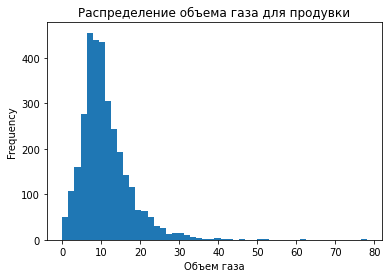

In [20]:
gr3=data_gas_new['Газ 1'].plot(kind='hist', bins=50, title='Распределение объема газа для продувки')
gr3.set_xlabel('Объем газа');

Conclusiones sobre data_gas_new:
 - key — número de lote;
 - Газ 1 — volumen de gas suministrado;
 - No se observan valores atípicos evidentes; la distribución está sesgada hacia valores bajos y corresponde a una distribución lognormal.

##### Investigación del archivo data_temp_new.csv

In [21]:
# Resultados de las mediciones de temperatura
data_temp_new.info()
display(data_temp_new.describe())
display(data_temp_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000

key        Время замера  Температура
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0
2    1 2019-05-03 11:11:34       1618.0
3    1 2019-05-03 11:18:04       1601.0
4    1 2019-05-03 11:25:59       1606.0

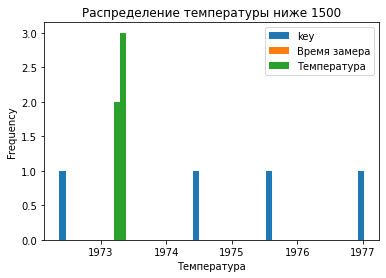

In [22]:
gr4=data_temp_new[data_temp_new['Температура']<=1500].plot(kind='hist', bins=50, title='Распределение температуры ниже 1500')
gr4.set_xlabel('Температура');

In [23]:
# Hay 5 valores atípicos de producción (relacionados con temperaturas inferiores al punto de fusión del acero), que serán eliminados durante el preprocesamiento de datos
data_temp_new[data_temp_new['Температура']<=1500]['Температура'].count()

5

Conclusiones sobre data_temp_new:

 - El tiempo de medición está en el formato correcto.

 - La variable temperatura (температура) contiene valores faltantes.

 - La variable temperatura presenta 5 valores atípicos de producción. 
- key — número de lote;
- Время замера — momento de la medición;
- Температура — valor de la temperatura.


##### Investigación del archivo data_wire_new.csv

In [24]:
# Datos sobre materiales en alambre (volumen) 
data_wire_new.info()
display(data_wire_new.describe())
display(data_wire_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [25]:
# Grado de completitud  
# Wire 1, Wire 2 están bien registrados  
(len(data_wire_new.key)-data_wire_new.isna().sum()).sort_values(ascending=False)

key       3081
Wire 1    3055
Wire 2    1079
Wire 6      73
Wire 3      63
Wire 9      29
Wire 8      19
Wire 4      14
Wire 7      11
Wire 5       1
dtype: int64

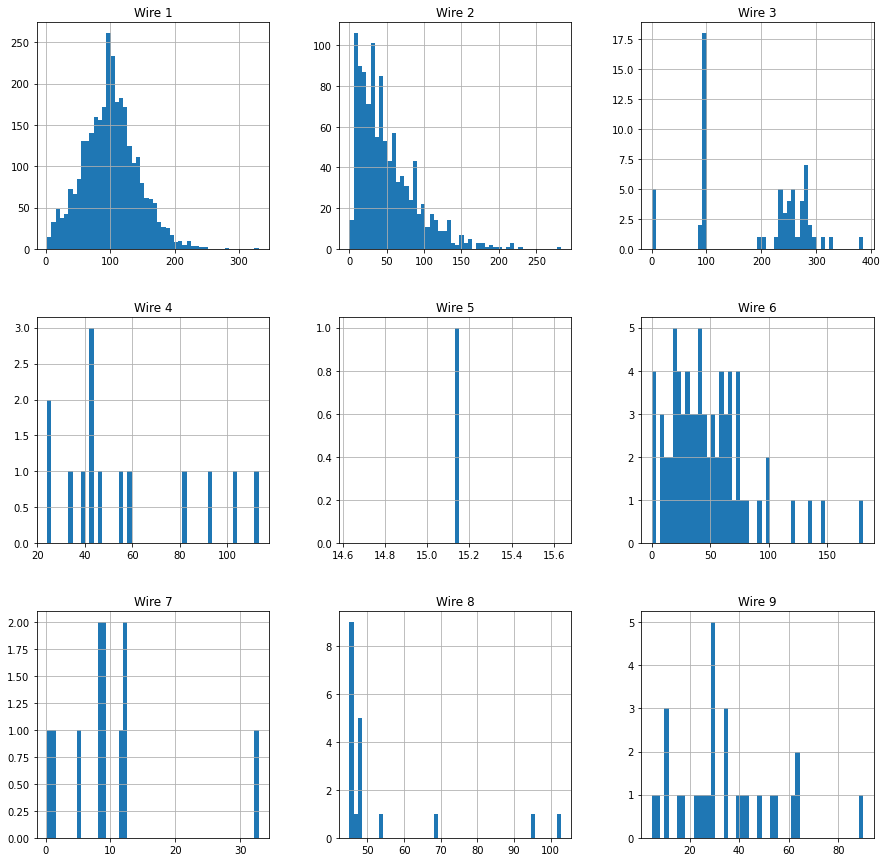

In [26]:
# Distribución de volúmenes 
data_wire_new.drop(['key'], axis=1).hist(bins=50, figsize=(15, 15));

Conclusiones sobre data_wire_new:
 - key — número de lote;
 - Wire 1 … Wire 9 — volumen de los materiales en alambre suministrados.
 - Hay muchos valores faltantes en varias variables (el material no se añadió a la cuchara).
 - Buena completitud en las variables Wire 1 y Wire 2.

 - Donde se suministraron grandes volúmenes, la distribución es normal; donde los volúmenes fueron menores, la distribución es lognormal, sesgada hacia valores bajos.

##### Investigación del archivo data_wire_time_new.csv

In [27]:
# Datos sobre materiales en alambre (tiempo)
data_wire_time_new.info()
display(data_wire_time_new.describe())
display( data_wire_time_new.head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

key              Wire 1              Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0     1 2019-05-03 11:06:19                 NaT    NaT    NaT    NaT    NaT   
1     2 2019-05-03 11:36:50                 NaT    NaT    NaT    NaT    NaT   
2     3 2019-05-03 12:11:46                 NaT    NaT    NaT    NaT    NaT   
3     4 2019-05-03 12:43:22                 NaT    NaT    NaT    NaT    NaT   
4     5 2019-05-03 13:20:44 2019-05-03 13:15:34    NaT    NaT    NaT    NaT   
5     6 2019-05-03 13:57:27 2019-05-03 13:48:52    NaT    NaT    NaT    NaT   
6     7 2019-05-03 14:18:58                 NaT    NaT    NaT    NaT    NaT   
7     8 2019-05-03 15:01:30                 NaT    NaT    NaT    NaT    NaT   
8     9 2019-05-03 15:45:44 2019-05-03 15:39:37    NaT    NaT    NaT    NaT   
9    10 2019-05-03 16:27:00 2019-05-03 16:22:36    NaT    NaT    NaT    NaT   
10   11 2019-05-03 16:55:14                 NaT    NaT    NaT    NaT    NaT   
11   12 2019-05-03 17:42:46                 NaT    NaT    NaT    NaT    NaT   
12   13 2019-05-03 18:48:32 2019-05-03 18:40:57    NaT    NaT    NaT    NaT   
13   14 2019-05-03 20:13:48 2019-05-03 20:02:42    NaT    NaT    NaT    NaT   
14   15 2019-05-03 21:07:19 2019-05-03 21:00:19    NaT    NaT    NaT    NaT   
15   16 2019-05-03 22:17:49 2019-05-03 22:07:59    NaT    NaT    NaT    NaT   
16   17 2019-05-03 23:01:58 2019-05-03 22:52:57    NaT    NaT    NaT    NaT   
17   18 2019-05-03 23:40:36 2019-05-03 23:26:15    NaT    NaT    NaT    NaT   
18   19 2019-05-04 00:57:11 2019-05-04 00:44:32    NaT    NaT    NaT    NaT   
19   20 2019-05-04 02:05:50 2019-05-04 02:00:27    NaT    NaT    NaT    NaT   

   Wire 7 Wire 8 Wire 9  
0     NaT    NaT    NaT  
1     NaT    NaT    NaT  
2     NaT    NaT    NaT  
3     NaT    NaT    NaT  
4     NaT    NaT    NaT  
5     NaT    NaT    NaT  
6     NaT    NaT    NaT  
7     NaT    NaT    NaT  
8     NaT    NaT    NaT  
9     NaT    NaT    NaT  
10    NaT    NaT    NaT  
11    NaT    NaT    NaT  
12    NaT    NaT    NaT  
13    NaT    NaT    NaT  
14    NaT    NaT    NaT  
15    NaT    NaT    NaT  
16    NaT    NaT    NaT  
17    NaT    NaT    NaT  
18    NaT    NaT    NaT  
19    NaT    NaT    NaT

Conclusiones sobre data_wire_time_new:

 - Wire 1 … Wire 9 están cargados en formato datetime64.

 - key — número de lote;

 - Wire 1 … Wire 9 — tiempo de alimentación de los materiales en alambre.

### Preprocesamiento de datos

#### Eliminación de anomalías de producción

Condiciones:

 - Eliminar la clave con potencia reactiva negativa.

 - Eliminar la clave con temperaturas <1500 (punto de fusión del acero).

 - Estos son valores atípicos de producción.

 - Los demás valores atípicos se eliminan solo en el conjunto de entrenamiento (para no mejorar artificialmente los resultados en el conjunto de prueba).

In [28]:
# Eliminación de la clave con potencia reactiva negativa - realizado
data_arc_new=data_arc_new[data_arc_new['Реактивная мощность']>=0]
data_arc_new[data_arc_new['Реактивная мощность']<=0]

Empty DataFrame
Columns: [key, Начало нагрева дугой, Конец нагрева дугой, Активная мощность, Реактивная мощность]
Index: []

In [29]:
# Eliminación de la clave con temperaturas <1500 (punto de fusión del acero) - realizado
data_temp_new=data_temp_new[data_temp_new['Температура']>=1500]
data_temp_new[data_temp_new['Температура']<=1500]

Empty DataFrame
Columns: [key, Время замера, Температура]
Index: []

#### Eliminación de claves con una sola medición de temperatura

Condiciones:

 - Eliminar las claves con una sola medición de temperatura, ya que no son adecuadas para el modelado (se necesitan valores inicial y final).

In [30]:
key_counts = data_temp_new['key'].value_counts()
key_counts

2108    17
1513    16
1689    16
46      14
322     14
        ..
3236     1
2963     1
2955     1
2947     1
2525     1
Name: key, Length: 3215, dtype: int64

In [31]:
valid_keys = key_counts[key_counts > 1].index
valid_keys

Int64Index([2108, 1513, 1689,   46,  322,   44, 1829,  638, 1958, 1880,
            ...
             661,  977, 1369,  112, 1281, 2194, 1449,  530, 2112,  269],
           dtype='int64', length=2475)

In [32]:
data_temp_new = data_temp_new[data_temp_new['key'].isin(valid_keys)]
(data_temp_new['key'].value_counts()==1).sum()

0

#### Eliminación de temperaturas intermedias en el lote, creación de la variable “Número de iteraciones”

Condiciones:

 - Solo se puede analizar la primera temperatura del lote (medida antes de iniciar los estudios).

 - Los valores intermedios deben eliminarse, ya que pueden provocar fuga de datos.

 - Además, en esta etapa se creó la variable Número de iteraciones (Количество итераций)

In [33]:
data_temp_new.head(15)

key        Время замера  Температура
0     1 2019-05-03 11:02:04       1571.0
1     1 2019-05-03 11:07:18       1604.0
2     1 2019-05-03 11:11:34       1618.0
3     1 2019-05-03 11:18:04       1601.0
4     1 2019-05-03 11:25:59       1606.0
5     1 2019-05-03 11:30:38       1613.0
6     2 2019-05-03 11:34:04       1581.0
7     2 2019-05-03 11:38:40       1577.0
8     2 2019-05-03 11:46:09       1589.0
9     2 2019-05-03 11:49:38       1604.0
10    2 2019-05-03 11:55:09       1602.0
11    3 2019-05-03 12:06:44       1596.0
12    3 2019-05-03 12:13:42       1597.0
13    3 2019-05-03 12:18:46       1598.0
14    3 2019-05-03 12:25:33       1599.0

In [34]:
# Creación de la variable temporal - Número de iteraciones 
data_add=data_temp_new.groupby('key').count()['Время замера']
data_add

key
1       6
2       5
3       6
4       5
5       5
       ..
2495    5
2496    7
2497    4
2498    6
2499    5
Name: Время замера, Length: 2475, dtype: int64

In [35]:
# Registro de la variable en el dataframe
data_temp_new['Количество итераций'] = data_temp_new.key.map(data_add)
data_temp_new.head()

key        Время замера  Температура  Количество итераций
0    1 2019-05-03 11:02:04       1571.0                    6
1    1 2019-05-03 11:07:18       1604.0                    6
2    1 2019-05-03 11:11:34       1618.0                    6
3    1 2019-05-03 11:18:04       1601.0                    6
4    1 2019-05-03 11:25:59       1606.0                    6

In [36]:
data_temp_new=data_temp_new.groupby("key").apply(lambda x: x.iloc[[0, -1]]).reset_index(drop=True)
data_temp_new.head(6)

key        Время замера  Температура  Количество итераций
0    1 2019-05-03 11:02:04       1571.0                    6
1    1 2019-05-03 11:30:38       1613.0                    6
2    2 2019-05-03 11:34:04       1581.0                    5
3    2 2019-05-03 11:55:09       1602.0                    5
4    3 2019-05-03 12:06:44       1596.0                    6
5    3 2019-05-03 12:35:57       1599.0                    6

#### Tratamiento de valores faltantes para los materiales suministrados

Condiciones:

 - Si en los datos de materiales añadidos hay valores faltantes, significa que el material no se suministró en esa iteración a la cuchara, por lo que los faltantes deben rellenarse con ceros.

 - Las tablas sobre el tiempo de alimentación de materiales no se incluirán en la tabla final; se utilizan únicamente para verificar la coherencia de los datos.

In [37]:
data_bulk_new.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [38]:
s = (len(data_bulk_new['key'])-(data_bulk_new.isna().sum())).sort_values(ascending=False)>=(len(data_bulk_new['key']))*0.8

In [39]:
s.index[s]

Index(['key', 'Bulk 14'], dtype='object')

In [40]:
data_bulk_new=data_bulk_new[s.index[s].to_list()]
data_bulk_new.head()

key  Bulk 14
0    1    150.0
1    2    149.0
2    3    152.0
3    4    153.0
4    5    151.0

In [41]:
data_bulk_new['Bulk 14'].isna().sum()

323

In [42]:
data_bulk_new['Bulk 14']=data_bulk_new['Bulk 14'].fillna(0)
data_bulk_new['Bulk 14'].isna().sum()

0

In [43]:
data_wire_new.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [44]:
s1 = (len(data_wire_new['key'])-(data_wire_new.isna().sum())).sort_values(ascending=False)>=(len(data_wire_new['key']))*0.8
s1

key        True
Wire 1     True
Wire 2    False
Wire 6    False
Wire 3    False
Wire 9    False
Wire 8    False
Wire 4    False
Wire 7    False
Wire 5    False
dtype: bool

In [45]:
s1.index[s1]

Index(['key', 'Wire 1'], dtype='object')

In [46]:
data_wire_new=data_wire_new[s1.index[s1].to_list()]
data_wire_new.head()

key     Wire 1
0    1  60.059998
1    2  96.052315
2    3  91.160157
3    4  89.063515
4    5  89.238236

In [47]:
data_wire_new['Wire 1']=data_wire_new['Wire 1'].fillna(0)
data_wire_new['Wire 1'].isna().sum()

0

#### Agregación de parámetros

Condiciones:

 - El objeto de modelado es el lote completo, por lo tanto, los datos se agregarán por lotes. Se calculará la suma.

In [48]:
data_arc_new.head(10)

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   
5    2  2019-05-03 11:34:14 2019-05-03 11:36:31           0.381124   
6    2  2019-05-03 11:38:50 2019-05-03 11:44:28           0.261665   
7    2  2019-05-03 11:46:19 2019-05-03 11:48:25           0.710297   
8    2  2019-05-03 11:49:48 2019-05-03 11:53:18           0.786322   
9    3  2019-05-03 12:06:54 2019-05-03 12:11:34           1.101678   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
5             0.220351  
6             0.205527  
7             0.484962  
8             0.542517  
9             0.820856

In [49]:
# Agregación de datos
agg_data = data_arc_new.groupby("key").agg({
    "Активная мощность": "sum",
    "Реактивная мощность": "sum"
}).reset_index()


In [50]:
# Cambio de nombre de la columna para la nueva variable
agg_data.rename(columns={
    "Активная мощность": "Суммарная активная мощность",
    "Реактивная мощность": "Суммарная реактивная мощность"
}, inplace=True)

In [51]:
# Unión de los datos agregados con el DataFrame original
data_arc_new = data_arc_new.merge(agg_data, on="key", how="left")
data_arc_new.head(10)

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   
5    2  2019-05-03 11:34:14 2019-05-03 11:36:31           0.381124   
6    2  2019-05-03 11:38:50 2019-05-03 11:44:28           0.261665   
7    2  2019-05-03 11:46:19 2019-05-03 11:48:25           0.710297   
8    2  2019-05-03 11:49:48 2019-05-03 11:53:18           0.786322   
9    3  2019-05-03 12:06:54 2019-05-03 12:11:34           1.101678   

   Реактивная мощность  Суммарная активная мощность  \
0             0.211253                     3.036730   
1             0.477438                     3.036730   
2             0.430460                     3.036730   
3             0.379979                     3.036730   
4             0.643691                     3.036730   
5             0.220351                     2.139408   
6             0.205527                     2.139408   
7             0.484962                     2.139408   
8             0.542517                     2.139408   
9             0.820856                     4.063641   

   Суммарная реактивная мощность  
0                       2.142821  
1                       2.142821  
2                       2.142821  
3                       2.142821  
4                       2.142821  
5                       1.453357  
6                       1.453357  
7                       1.453357  
8                       1.453357  
9                       2.937457

### Adición de variables (features)

#### Magnitudes físicas

Condiciones:
 - Полная мощность - Potencia aparente: raíz cuadrada de la suma de los cuadrados de la potencia activa y reactiva.
 - Работа - Trabajo: producto de la potencia aparente y el tiempo de calentamiento.
 - Número de iteraciones: según el plan elaborado antes de iniciar los estudios (no constituye fuga de datos).

In [52]:
# Adición de la potencia aparente 
data_arc_new['Полная мощность']=(data_arc_new['Активная мощность']**2+data_arc_new['Реактивная мощность']**2)**0.5
# Adición de la potencia aparente total
data_arc_new['Суммарная полная мощность']=(data_arc_new['Суммарная активная мощность']**2+data_arc_new['Суммарная реактивная мощность']**2)**0.5
data_arc_new.head()

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

   Реактивная мощность  Суммарная активная мощность  \
0             0.211253                      3.03673   
1             0.477438                      3.03673   
2             0.430460                      3.03673   
3             0.379979                      3.03673   
4             0.643691                      3.03673   

   Суммарная реактивная мощность  Полная мощность  Суммарная полная мощность  
0                       2.142821         0.371123                    3.71664  
1                       2.142821         0.902319                    3.71664  
2                       2.142821         0.722536                    3.71664  
3                       2.142821         0.642824                    3.71664  
4                       2.142821         1.079934                    3.71664

In [53]:
# Adición del parámetro - Tiempo de calentamiento por arco
data_arc_new['Время нагрева дугой']=data_arc_new['Конец нагрева дугой']-data_arc_new['Начало нагрева дугой']

In [54]:
agg_data2=data_arc_new.groupby('key').agg({'Время нагрева дугой':'sum'}).reset_index()
agg_data2.columns = ['key', 'Суммарное время нагрева дугой']

In [55]:
data_arc_new = data_arc_new.merge(agg_data2, on="key", how="left")
data_arc_new.head(20)

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0     1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1     1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2     1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3     1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4     1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   
5     2  2019-05-03 11:34:14 2019-05-03 11:36:31           0.381124   
6     2  2019-05-03 11:38:50 2019-05-03 11:44:28           0.261665   
7     2  2019-05-03 11:46:19 2019-05-03 11:48:25           0.710297   
8     2  2019-05-03 11:49:48 2019-05-03 11:53:18           0.786322   
9     3  2019-05-03 12:06:54 2019-05-03 12:11:34           1.101678   
10    3  2019-05-03 12:13:52 2019-05-03 12:15:56           0.542675   
11    3  2019-05-03 12:18:56 2019-05-03 12:20:45           0.774632   
12    3  2019-05-03 12:25:43 2019-05-03 12:27:00           1.222963   
13    3  2019-05-03 12:31:14 2019-05-03 12:32:19           0.421693   
14    4  2019-05-03 12:39:37 2019-05-03 12:43:04           0.642946   
15    4  2019-05-03 12:44:47 2019-05-03 12:46:26           0.310693   
16    4  2019-05-03 12:48:14 2019-05-03 12:50:51           0.887855   
17    4  2019-05-03 12:53:12 2019-05-03 12:57:50           0.864995   
18    5  2019-05-03 13:11:13 2019-05-03 13:15:24           0.324563   
19    5  2019-05-03 13:18:21 2019-05-03 13:20:33           0.573810   

    Реактивная мощность  Суммарная активная мощность  \
0              0.211253                     3.036730   
1              0.477438                     3.036730   
2              0.430460                     3.036730   
3              0.379979                     3.036730   
4              0.643691                     3.036730   
5              0.220351                     2.139408   
6              0.205527                     2.139408   
7              0.484962                     2.139408   
8              0.542517                     2.139408   
9              0.820856                     4.063641   
10             0.474673                     4.063641   
11             0.505690                     4.063641   
12             0.863676                     4.063641   
13             0.272562                     4.063641   
14             0.516071                     2.706489   
15             0.241781                     2.706489   
16             0.644479                     2.706489   
17             0.654661                     2.706489   
18             0.279102                     2.252950   
19             0.439417                     2.252950   

    Суммарная реактивная мощность  Полная мощность  Суммарная полная мощность  \
0                        2.142821         0.371123                   3.716640   
1                        2.142821         0.902319                   3.716640   
2                        2.142821         0.722536                   3.716640   
3                        2.142821         0.642824                   3.716640   
4                        2.142821         1.079934                   3.716640   
5                        1.453357         0.440239                   2.586371   
6                        1.453357         0.332731                   2.586371   
7                        1.453357         0.860064                   2.586371   
8                        1.453357         0.955315                   2.586371   
9                        2.937457         1.373863                   5.014163   
10                       2.937457         0.720979                   5.014163   
11                       2.937457         0.925082                   5.014163   
12                       2.937457         1.497189                   5.014163   
13                       2.937457         0.502111                   5.014163   
14                       2.056992         0.824445                   3.399456   
15                       2.056992      

In [56]:
data_arc_new['Суммарное время нагрева дугой sec'] = data_arc_new['Суммарное время нагрева дугой'].dt.seconds

In [57]:
# Adición del Trabajo
data_arc_new['Суммарная работа']=data_arc_new['Суммарная полная мощность']*data_arc_new['Суммарное время нагрева дугой sec']
data_arc_new.head()

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

   Реактивная мощность  Суммарная активная мощность  \
0             0.211253                      3.03673   
1             0.477438                      3.03673   
2             0.430460                      3.03673   
3             0.379979                      3.03673   
4             0.643691                      3.03673   

   Суммарная реактивная мощность  Полная мощность  Суммарная полная мощность  \
0                       2.142821         0.371123                    3.71664   
1                       2.142821         0.902319                    3.71664   
2                       2.142821         0.722536                    3.71664   
3                       2.142821         0.642824                    3.71664   
4                       2.142821         1.079934                    3.71664   

  Время нагрева дугой Суммарное время нагрева дугой  \
0     0 days 00:03:48               0 days 00:18:18   
1     0 days 00:03:05               0 days 00:18:18   
2     0 days 00:02:52               0 days 00:18:18   
3     0 days 00:06:05               0 days 00:18:18   
4     0 days 00:02:28               0 days 00:18:18   

   Суммарное время нагрева дугой sec  Суммарная работа  
0                               1098       4080.870431  
1                               1098       4080.870431  
2                               1098       4080.870431  
3                               1098       4080.870431  
4                               1098       4080.870431

#### Variables basadas en el tiempo

Condiciones:
 - Время нагрева дугой - El tiempo de calentamiento por arco ya está calculado.
 - El tiempo entre la primera y la última medición de temperatura.

 - El número de iteraciones.

In [58]:
# Tiempo de medición entre la primera y la última temperaturas
data_temp_new['Временной интервал'] = data_temp_new.groupby('key')['Время замера'].transform(lambda x: x.iloc[1] - x.iloc[0])
data_temp_new['Временной интервал сек']=data_temp_new['Временной интервал'].dt.seconds
data_temp_new.head()

key        Время замера  Температура  Количество итераций  \
0    1 2019-05-03 11:02:04       1571.0                    6   
1    1 2019-05-03 11:30:38       1613.0                    6   
2    2 2019-05-03 11:34:04       1581.0                    5   
3    2 2019-05-03 11:55:09       1602.0                    5   
4    3 2019-05-03 12:06:44       1596.0                    6   

  Временной интервал  Временной интервал сек  
0    0 days 00:28:34                    1714  
1    0 days 00:28:34                    1714  
2    0 days 00:21:05                    1265  
3    0 days 00:21:05                    1265  
4    0 days 00:29:13                    1753

### Unificación de datos

Condiciones:

 - Unificación de tablas con INNER JOIN (se toman los lotes que están presentes en todas las tablas).

 - No debe haber más de 2332 claves.

- No debe haber claves con números superiores a 2500 (se usará .tail() para la verificación).

In [59]:
# Preparación adicional de las tablas para la unificación  
data_arc_new.set_index('key', inplace=True)
data_bulk_new.set_index('key', inplace=True)
data_gas_new.set_index('key', inplace=True)
data_temp_new.set_index('key', inplace=True)
data_wire_new.set_index('key', inplace=True)

In [60]:
data_arc_new=data_arc_new.drop(columns=['Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность', 'Полная мощность', 'Время нагрева дугой'])
data_arc_new.head()

Суммарная активная мощность  Суммарная реактивная мощность  \
key                                                               
1                        3.03673                       2.142821   
1                        3.03673                       2.142821   
1                        3.03673                       2.142821   
1                        3.03673                       2.142821   
1                        3.03673                       2.142821   

     Суммарная полная мощность Суммарное время нагрева дугой  \
key                                                            
1                      3.71664               0 days 00:18:18   
1                      3.71664               0 days 00:18:18   
1                      3.71664               0 days 00:18:18   
1                      3.71664               0 days 00:18:18   
1                      3.71664               0 days 00:18:18   

     Суммарное время нагрева дугой sec  Суммарная работа  
key                                                       
1                                 1098       4080.870431  
1                                 1098       4080.870431  
1                                 1098       4080.870431  
1                                 1098       4080.870431  
1                                 1098       4080.870431

In [61]:
data_arc_new=data_arc_new.groupby('key').agg('mean')
data_arc_new.head()

Суммарная активная мощность  Суммарная реактивная мощность  \
key                                                               
1                       3.036730                       2.142821   
2                       2.139408                       1.453357   
3                       4.063641                       2.937457   
4                       2.706489                       2.056992   
5                       2.252950                       1.687991   

     Суммарная полная мощность  Суммарное время нагрева дугой sec  \
key                                                                 
1                     3.716640                               1098   
2                     2.586371                                811   
3                     5.014163                                655   
4                     3.399456                                741   
5                     2.815155                                869   

     Суммарная работа  
key                    
1         4080.870431  
2         2097.546600  
3         3284.276844  
4         2518.996645  
5         2446.369640

In [62]:
# Unificación de las tablas  
final_table=data_temp_new.join([data_bulk_new, data_gas_new, data_arc_new, data_wire_new], 
                              how='inner')

In [63]:
final_table=final_table.reset_index()
final_table.head()

key        Время замера  Температура  Количество итераций  \
0    1 2019-05-03 11:02:04       1571.0                    6   
1    1 2019-05-03 11:30:38       1613.0                    6   
2    2 2019-05-03 11:34:04       1581.0                    5   
3    2 2019-05-03 11:55:09       1602.0                    5   
4    3 2019-05-03 12:06:44       1596.0                    6   

  Временной интервал  Временной интервал сек  Bulk 14      Газ 1  \
0    0 days 00:28:34                    1714    150.0  29.749986   
1    0 days 00:28:34                    1714    150.0  29.749986   
2    0 days 00:21:05                    1265    149.0  12.555561   
3    0 days 00:21:05                    1265    149.0  12.555561   
4    0 days 00:29:13                    1753    152.0  28.554793   

   Суммарная активная мощность  Суммарная реактивная мощность  \
0                     3.036730                       2.142821   
1                     3.036730                       2.142821   
2                     2.139408                       1.453357   
3                     2.139408                       1.453357   
4                     4.063641                       2.937457   

   Суммарная полная мощность  Суммарное время нагрева дугой sec  \
0                   3.716640                               1098   
1                   3.716640                               1098   
2                   2.586371                                811   
3                   2.586371                                811   
4                   5.014163                                655   

   Суммарная работа     Wire 1  
0       4080.870431  60.059998  
1       4080.870431  60.059998  
2       2097.546600  96.052315  
3       2097.546600  96.052315  
4       3284.276844  91.160157

In [64]:
final_table=pd.concat([
    final_table.groupby('key')['Время замера'].min(),
    final_table.groupby('key')['Время замера'].max(),
    final_table.groupby('key')['Температура'].first(),
    final_table.groupby('key')['Температура'].last(),
    final_table.groupby('key')[['Количество итераций', 'Временной интервал сек', 'Bulk 14', 'Wire 1', 'Газ 1', 'Суммарная активная мощность', 'Суммарная реактивная мощность', 'Суммарная полная мощность', 'Суммарное время нагрева дугой sec', 'Суммарная работа']].first()
], axis=1).reset_index()
final_table.columns=['key', 'Время замера начало', 'Время замера конец', 'Температура начало', 'Температура конец', 'Количество итераций', 'Временной интервал сек', 'Bulk 14', 'Wire 1', 'Газ 1', 'Суммарная активная мощность', 'Суммарная реактивная мощность', 'Суммарная полная мощность', 'Суммарное время нагрева дугой sec', 'Суммарная работа']

In [65]:
final_table.head()

key Время замера начало  Время замера конец  Температура начало  \
0    1 2019-05-03 11:02:04 2019-05-03 11:30:38              1571.0   
1    2 2019-05-03 11:34:04 2019-05-03 11:55:09              1581.0   
2    3 2019-05-03 12:06:44 2019-05-03 12:35:57              1596.0   
3    4 2019-05-03 12:39:27 2019-05-03 12:59:47              1601.0   
4    5 2019-05-03 13:11:03 2019-05-03 13:36:39              1576.0   

   Температура конец  Количество итераций  Временной интервал сек  Bulk 14  \
0             1613.0                    6                    1714    150.0   
1             1602.0                    5                    1265    149.0   
2             1599.0                    6                    1753    152.0   
3             1625.0                    5                    1220    153.0   
4             1602.0                    5                    1536    151.0   

      Wire 1      Газ 1  Суммарная активная мощность  \
0  60.059998  29.749986                     3.036730   
1  96.052315  12.555561                     2.139408   
2  91.160157  28.554793                     4.063641   
3  89.063515  18.841219                     2.706489   
4  89.238236   5.413692                     2.252950   

   Суммарная реактивная мощность  Суммарная полная мощность  \
0                       2.142821                   3.716640   
1                       1.453357                   2.586371   
2                       2.937457                   5.014163   
3                       2.056992                   3.399456   
4                       1.687991                   2.815155   

   Суммарное время нагрева дугой sec  Суммарная работа  
0                               1098       4080.870431  
1                                811       2097.546600  
2                                655       3284.276844  
3                                741       2518.996645  
4                                869       2446.369640

In [66]:
if final_table['key'].value_counts().sum()<2332:
    print('Должно быть не более 2332 ключей - условие выполнено')
else:
    print('Должно быть не более 2332 ключей - условие НЕ выполнено')

Должно быть не более 2332 ключей - условие выполнено


In [67]:
# No debe haber claves con números superiores a 2500 
final_table['key'].tail(10)

2319    2489
2320    2490
2321    2492
2322    2493
2323    2494
2324    2495
2325    2496
2326    2497
2327    2498
2328    2499
Name: key, dtype: int64

### Análisis exploratorio de los datos unificados

Condiciones:

 - Eliminación de la clave.

 - Gráficos para todas las variables (histogramas, boxplots).

In [68]:
# Eliminación de la clave
final_table=final_table.drop('key', axis=1)

In [69]:
final_table.head()

Время замера начало  Время замера конец  Температура начало  \
0 2019-05-03 11:02:04 2019-05-03 11:30:38              1571.0   
1 2019-05-03 11:34:04 2019-05-03 11:55:09              1581.0   
2 2019-05-03 12:06:44 2019-05-03 12:35:57              1596.0   
3 2019-05-03 12:39:27 2019-05-03 12:59:47              1601.0   
4 2019-05-03 13:11:03 2019-05-03 13:36:39              1576.0   

   Температура конец  Количество итераций  Временной интервал сек  Bulk 14  \
0             1613.0                    6                    1714    150.0   
1             1602.0                    5                    1265    149.0   
2             1599.0                    6                    1753    152.0   
3             1625.0                    5                    1220    153.0   
4             1602.0                    5                    1536    151.0   

      Wire 1      Газ 1  Суммарная активная мощность  \
0  60.059998  29.749986                     3.036730   
1  96.052315  12.555561                     2.139408   
2  91.160157  28.554793                     4.063641   
3  89.063515  18.841219                     2.706489   
4  89.238236   5.413692                     2.252950   

   Суммарная реактивная мощность  Суммарная полная мощность  \
0                       2.142821                   3.716640   
1                       1.453357                   2.586371   
2                       2.937457                   5.014163   
3                       2.056992                   3.399456   
4                       1.687991                   2.815155   

   Суммарное время нагрева дугой sec  Суммарная работа  
0                               1098       4080.870431  
1                                811       2097.546600  
2                                655       3284.276844  
3                                741       2518.996645  
4                                869       2446.369640

In [70]:
final_table_for_analysis=final_table.drop(columns=['Время замера начало','Время замера конец'])
final_table_for_analysis.head()

Температура начало  Температура конец  Количество итераций  \
0              1571.0             1613.0                    6   
1              1581.0             1602.0                    5   
2              1596.0             1599.0                    6   
3              1601.0             1625.0                    5   
4              1576.0             1602.0                    5   

   Временной интервал сек  Bulk 14     Wire 1      Газ 1  \
0                    1714    150.0  60.059998  29.749986   
1                    1265    149.0  96.052315  12.555561   
2                    1753    152.0  91.160157  28.554793   
3                    1220    153.0  89.063515  18.841219   
4                    1536    151.0  89.238236   5.413692   

   Суммарная активная мощность  Суммарная реактивная мощность  \
0                     3.036730                       2.142821   
1                     2.139408                       1.453357   
2                     4.063641                       2.937457   
3                     2.706489                       2.056992   
4                     2.252950                       1.687991   

   Суммарная полная мощность  Суммарное время нагрева дугой sec  \
0                   3.716640                               1098   
1                   2.586371                                811   
2                   5.014163                                655   
3                   3.399456                                741   
4                   2.815155                                869   

   Суммарная работа  
0       4080.870431  
1       2097.546600  
2       3284.276844  
3       2518.996645  
4       2446.369640

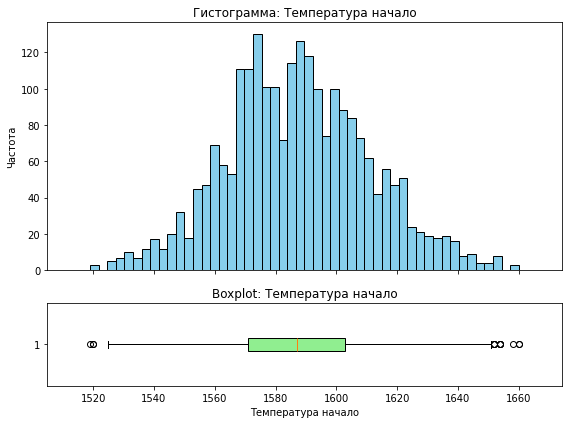

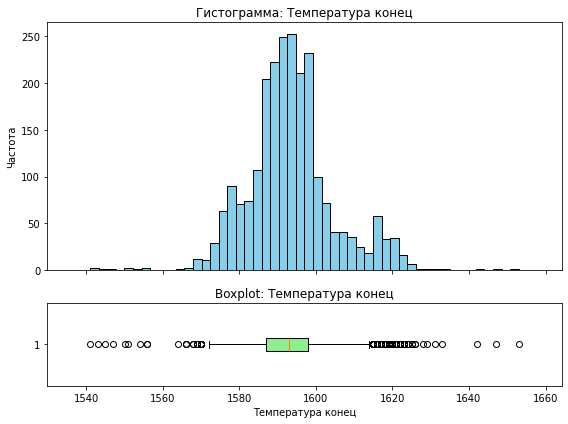

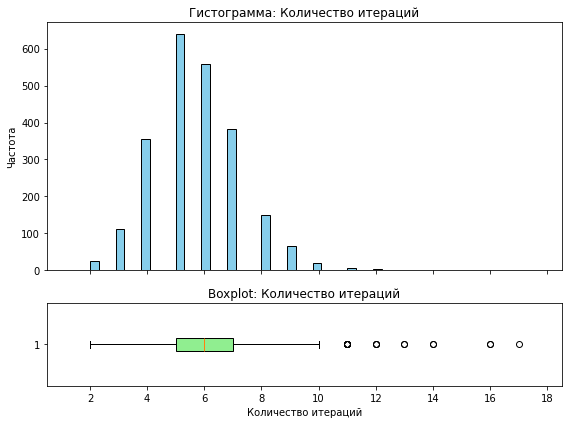

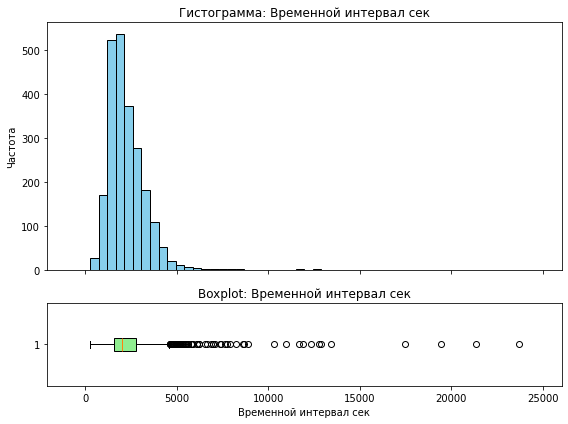

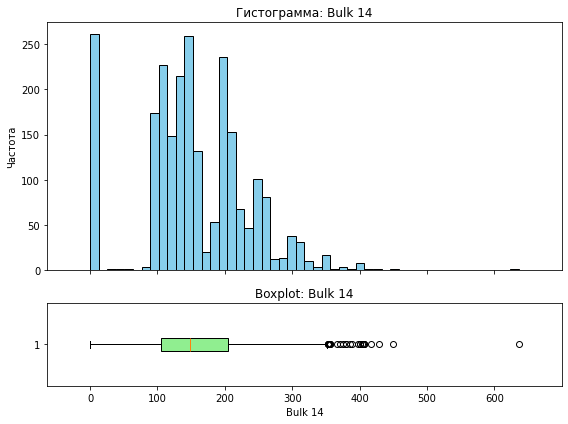

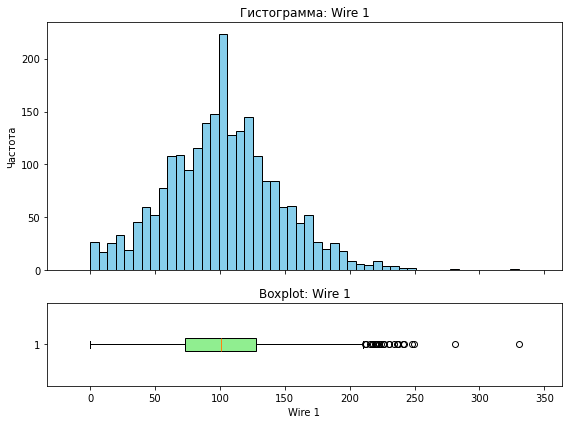

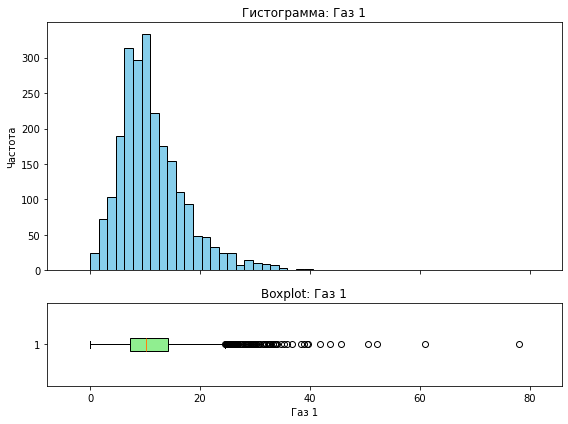

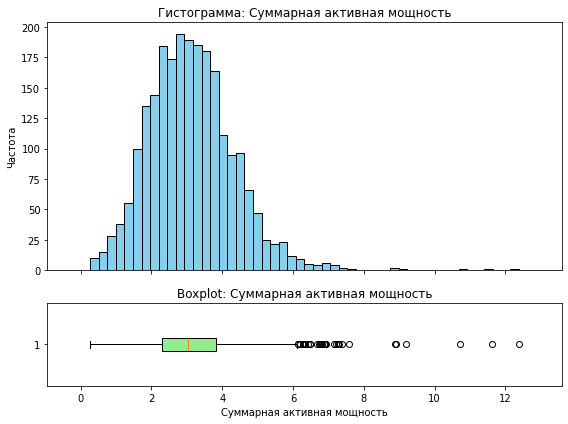

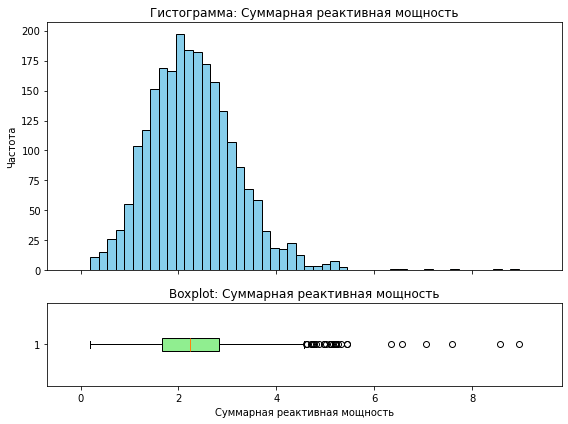

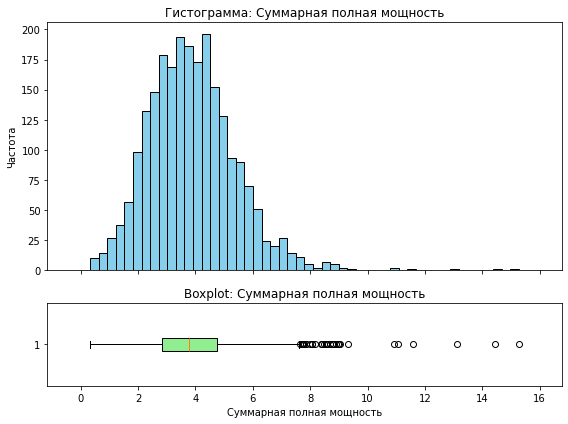

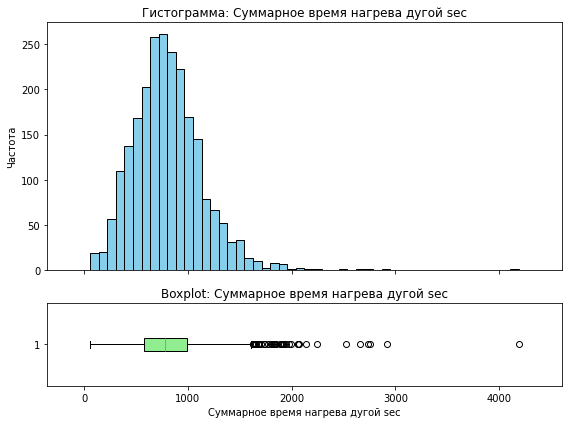

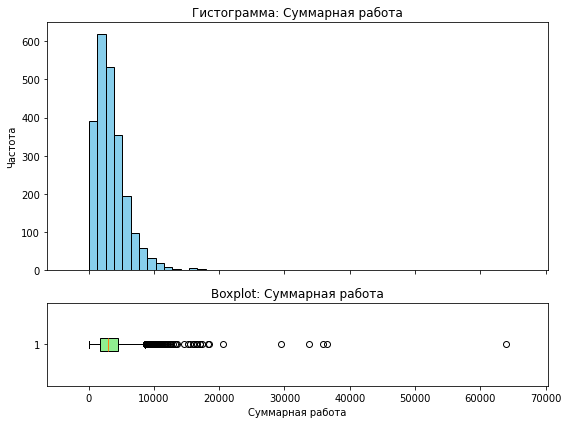

In [71]:
# Función para construir histograma y boxplot de cada variable numérica
for column in final_table_for_analysis.columns:
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

        # Histograma 
    axes[0].hist(final_table_for_analysis[column], bins=50, color='skyblue', edgecolor='black')
    axes[0].set_title(f'Гистограмма: {column}')
    axes[0].set_ylabel('Частота')

        # Boxplot
    axes[1].boxplot(final_table_for_analysis[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
    axes[1].set_title(f'Boxplot: {column}')
    axes[1].set_xlabel(column)

        # Escalado del eje X
    min_val = final_table_for_analysis[column].min()
    max_val = final_table_for_analysis[column].max()
    axes[0].set_xlim(min_val - (0.1 * abs(max_val - min_val)), max_val + (0.1 * abs(max_val - min_val)))
    axes[1].set_xlim(min_val - (0.1 * abs(max_val - min_val)), max_val + (0.1 * abs(max_val - min_val)))

        # Gráficos
    plt.tight_layout()
    plt.show()

In [72]:
final_table_for_analysis.describe()

Температура начало  Температура конец  Количество итераций  \
count         2329.000000        2329.000000          2329.000000   
mean          1587.386003        1593.365393             5.693860   
std             23.619841          11.200915             1.607639   
min           1519.000000        1541.000000             2.000000   
25%           1571.000000        1587.000000             5.000000   
50%           1587.000000        1593.000000             6.000000   
75%           1603.000000        1598.000000             7.000000   
max           1660.000000        1653.000000            17.000000   

       Временной интервал сек      Bulk 14       Wire 1        Газ 1  \
count             2329.000000  2329.000000  2329.000000  2329.000000   
mean              2321.810219   153.853585   102.443601    11.375600   
std               1385.191527    81.404354    43.539993     6.392041   
min                270.000000     0.000000     0.000000     0.008399   
25%               1579.000000   105.000000    73.207679     7.282948   
50%               2045.000000   149.000000   101.119201    10.100950   
75%               2791.000000   204.000000   128.091599    14.216688   
max              23674.000000   636.000000   330.314424    77.995040   

       Суммарная активная мощность  Суммарная реактивная мощность  \
count                  2329.000000                    2329.000000   
mean                      3.125033                       2.300522   
std                       1.221007                       0.903968   
min                       0.267676                       0.196228   
25%                       2.293900                       1.669572   
50%                       3.035365                       2.225398   
75%                       3.834300                       2.829159   
max                      12.375636                       8.949049   

       Суммарная полная мощность  Суммарное время нагрева дугой sec  \
count                2329.000000                        2329.000000   
mean                    3.881500                         807.600687   
std                     1.516643                         340.897332   
min                     0.331897                          57.000000   
25%                     2.841624                         581.000000   
50%                     3.767064                         778.000000   
75%                     4.767256                         993.000000   
max                    15.272257                        4189.000000   

       Суммарная работа  
count       2329.000000  
mean        3506.638477  
std         3036.853297  
min           33.430208  
25%         1708.483805  
50%         2902.122400  
75%         4511.394646  
max        63975.486018

Conclusiones del análisis exploratorio de los datos finales integrados:
 - La variable Temperatura inicial (Температура начало) sigue una distribución normal, sin valores atípicos ni anomalías evidentes.
 - La distribución de la variable Temperatura final (Температура конец) es más estrecha, pero en general tiene forma de distribución normal. Existen algunos valores bajos y altos en poca cantidad, sin valores atípicos de producción.
 - La variable Número de iteraciones (количество итераций) es una variable cuantitativa discreta, sin anomalías de producción.
 - La variable Intervalo de tiempo (Временной интервал) presenta una distribución lognormal, sesgada hacia valores bajos.
 - La variable Bulk 14 (alimentación de material a granel) presenta una distribución lognormal, también sesgada hacia valores bajos. Destacan los valores nulos (en esas iteraciones no se suministró material).
 - a variable Wire 1 sigue una distribución normal, sin valores atípicos ni anomalías.
 - La variable Gas 1 (Газ 1) presenta una distribución lognormal, sesgada hacia valores bajos.
 - Las variables Potencia activa total, Potencia reactiva total, Potencia aparente total y Tiempo total de calentamiento por arco segundos (Суммарная активная мощность, Суммарная реактивная мощность, Суммарная полная мощность, Суммарное время нагрева дугой sec) siguen distribuciones normales, sin valores atípicos o anomalías evidentes, aunque presentan una pequeña cantidad de valores altos.
 - La variable Trabajo total (Суммарная работа) presenta una distribución lognormal.
 

### Análisis de correlación de los datos

Condiciones:

 - Se generará una matriz de correlación con heatmap.

 - Se realizará una verificación de multicolinealidad (≥0.9), ya que se utilizará la regresión lineal. En caso de un coeficiente de correlación alto entre variables, se eliminará una de ellas.

In [73]:
final_table_for_analysis.columns

Index(['Температура начало', 'Температура конец', 'Количество итераций',
       'Временной интервал сек', 'Bulk 14', 'Wire 1', 'Газ 1',
       'Суммарная активная мощность', 'Суммарная реактивная мощность',
       'Суммарная полная мощность', 'Суммарное время нагрева дугой sec',
       'Суммарная работа'],
      dtype='object')

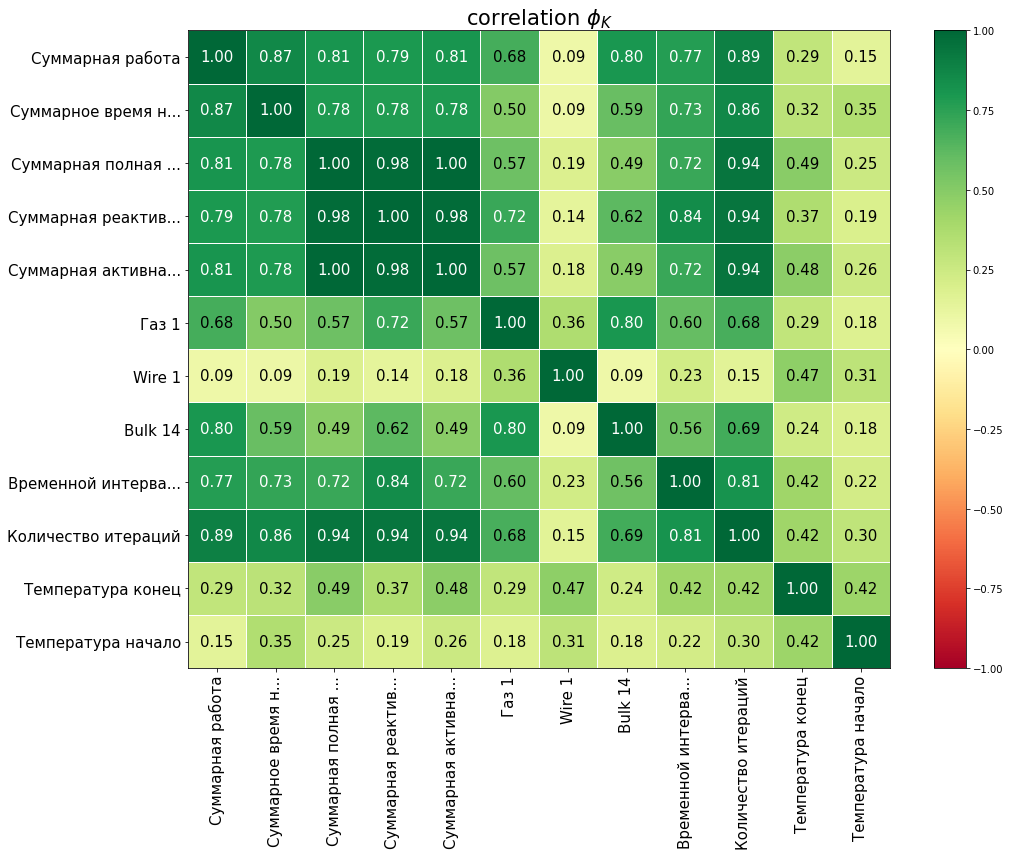

In [74]:
# Matriz de correlación phik para todas las variables, para relaciones lineales y no lineales.


interval_cols=['Температура начало', 'Температура конец',
       'Временной интервал сек', 'Bulk 14', 'Wire 1', 'Газ 1',
       'Суммарная активная мощность', 'Суммарная реактивная мощность',
       'Суммарная полная мощность', 'Суммарное время нагрева дугой sec',
       'Суммарная работа']

# Cálculo de los coeficientes de correlación phi para el dataframe df
phik_overview =final_table_for_analysis.phik_matrix(interval_cols)

# Visualización del mapa de calor de los coeficientes de correlación
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

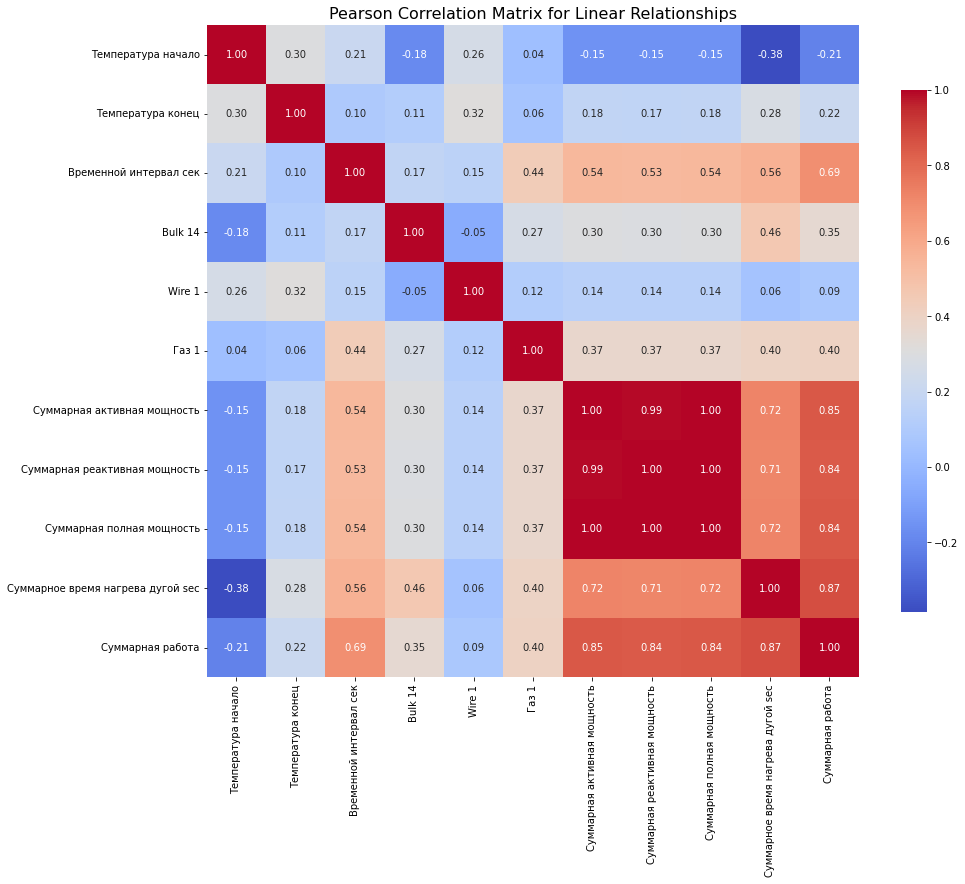

In [75]:
# Mapa de calor de la correlación lineal de Pearson
pearson_corr_matrix = final_table_for_analysis[interval_cols].corr(method='pearson')


plt.figure(figsize=(15, 12))
sns.heatmap(
    pearson_corr_matrix, 
    annot=True,   
    fmt=".2f",     
    cmap="coolwarm",  
    cbar_kws={'shrink': 0.8}, 
    square=True
)
plt.title("Pearson Correlation Matrix for Linear Relationships", fontsize=16)
plt.show()

Verificación de multicolinealidad según los resultados de la correlación Phi:
 - Potencia reactiva total, Potencia aparente total, Potencia activa total y Número de iteraciones (Суммарная реактивная мощность и Суммарная полная мощность и Суммарная активная мощность и количество итераций) presentan correlación >0.9 entre sí.
 - Se mantendrá únicamente la variable Potencia aparente total.

In [76]:
df_ml=final_table_for_analysis.drop(columns=['Суммарная активная мощность', 'Суммарная реактивная мощность', 'Количество итераций'])

Conclusiones:

 - Se ha formado el dataset df_ml, que será utilizado para el entrenamiento.

 - Los datos han sido preprocesados, unificados, analizados y se ha eliminado la multicolinealidad.

### División en conjuntos (train-test split)

Condiciones:

 - 1700 o más filas en el conjunto de entrenamiento.

 - Proporción 75% / 25%.
 - random_state = 91224
 

In [77]:
RANDOM_STATE=91224

In [78]:
X=df_ml.drop('Температура конец', axis=1)
y=df_ml['Температура конец']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)

In [80]:
# 1700 o más filas en el conjunto de entrenamiento  
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1746, 8), (583, 8), (1746,), (583,))

In [81]:
# Lista de variables cuantitativas  
num_columns = ['Температура начало', 'Временной интервал сек', 'Bulk 14', 'Wire 1',
       'Газ 1', 'Суммарная полная мощность',
       'Суммарное время нагрева дугой sec', 'Суммарная работа']

### Entrenamiento y selección del mejor modelo

Condiciones:

 - La normalización se realizará dentro del pipeline.

 - Entrenamiento de 2 o más modelos.

 - Uso de Dummy Regressor como modelo base.

 - Se ajustarán hiperparámetros (con búsqueda de al menos dos parámetros), excepto para el modelo de regresión lineal.

 - Para la selección del mejor modelo se utiliza RandomizedSearch o GridSearch.

 - Se usa el valor de la métrica en validación cruzada, con la métrica 'neg_mean_absolute_error', mostrando el resultado mediante best_score_.

 - No utilizar .predict.

In [82]:
# Pipeline para la preparación de características a partir de la lista num_columns
# Escalado con MinMaxScaler()
num_pipe = Pipeline(
    [
        (
            "simpleImputer_num",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
        (
            "scaler",
            MinMaxScaler(),
        ),  
    ]
)

# Pipeline general para la preparación de datos
data_preprocessor = ColumnTransformer(
    [
        ("num", num_pipe, num_columns),
    ],
    remainder="passthrough",
)

# Pipeline final: preparación de datos y modelo base - árbol de decisión
pipe_final = Pipeline(
    [
        ("preprocessor", data_preprocessor),
        ("models", DummyRegressor(strategy='mean')),
    ]
)

param_grid = [
    # Diccionario para el modelo DecisionTreeRegressor()
    {
        "models": [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        "models__max_depth": range(10, 15),
        "models__max_features": range(2, 9),
        "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(), "passthrough"],
    },
    # Modelo lineal
    {
        "models": [LinearRegression()],
        "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(), "passthrough"],
    },
]

In [83]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Selección del mejor modelo
GS = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_mean_absolute_error',
    error_score='raise',
    n_jobs=-1,    
)
GS.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', GS.best_estimator_)
print ('Метрика по кросс-валидации:', abs(GS.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Температура начало',
                                                   'Временной интервал сек',
                                                   'Bulk 14', 'Wire 1', 'Газ 1',
                                                   'Суммарная полная мощность',
                                                   'Суммарное время нагрева '
                                                   'дугой sec',
   

Resultados:

 - Se utilizó un pipeline.

 - Se probaron diferentes tipos de escalado de datos.

 - Se entrenaron dos modelos: DecisionTreeClassifier(), LinearRegression().

 - Para el modelo DecisionTreeClassifier() se ajustaron los hiperparámetros "models__max_depth" y "models__max_features".

 - Se utilizó GridSearchCV, que evaluó todas las combinaciones posibles.

 - El mejor modelo fue LinearRegression().

 - Métrica en validación cruzada: 6.2414663010830775.

 - El Dummy Regressor es el modelo base en el pipeline. Es posible que esta prueba con Dummy sea suficiente.

 - GridSearchCV no seleccionó el modelo base, por lo tanto el mejor modelo superó la prueba de adecuación.

### Prueba del mejor modelo

#### Prueba del mejor modelo

Condición:

 - Calcular e interpretar adicionalmente la métrica R² para el modelo.

In [84]:
model=GS.best_estimator_.named_steps['models']
model

LinearRegression()

In [85]:
preprocessor = GS.best_estimator_.named_steps['preprocessor']
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleImputer_num',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', StandardScaler())]),
                                 ['Температура начало',
                                  'Временной интервал сек', 'Bulk 14', 'Wire 1',
                                  'Газ 1', 'Суммарная полная мощность',
                                  'Суммарное время нагрева дугой sec',
                                  'Суммарная работа'])])

In [86]:
X_train_ = preprocessor.fit_transform(X_train)
X_test_ = preprocessor.transform(X_test)

In [87]:
model.fit(X_train_, y_train)

LinearRegression()

In [88]:
preds = model.predict(X_test_)

In [89]:

print(f'Метрика R2 на тестовой выборке для лучшей модели: {r2_score(y_test, preds)}')
print(f'Метрика MAE на тестовой выборке для лучшей модели: {mean_absolute_error(y_test, preds)}')

Метрика R2 на тестовой выборке для лучшей модели: 0.465787773978964
Метрика MAE на тестовой выборке для лучшей модели: 6.2489267146799765


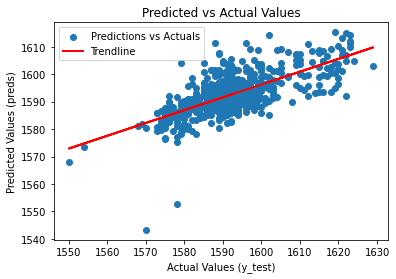

In [90]:
plt.scatter(y_test, preds, label="Predictions vs Actuals")

z = np.polyfit(y_test, preds, 1) 
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color="red", linewidth=2, label="Trendline")

plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (preds)")

plt.legend()

plt.show()

Interpretación de R²:
Además de la métrica MAE, el cliente solicitó calcular la métrica R². Aunque el valor de la métrica es relativamente bajo (0.46), en el gráfico se observa que la causa se debe únicamente a dos valores atípicos (predicciones poco precisas). En general, el modelo predijo correctamente casi todos los valores.


#### Importancia de las características

Condición:

 - Analizar la importancia de las características, se puede tomar las mas importantes.

In [91]:
X_train_ = pd.DataFrame(X_train_, columns=X_train.columns)
X_test_ = pd.DataFrame(X_test_, columns=X_test.columns)

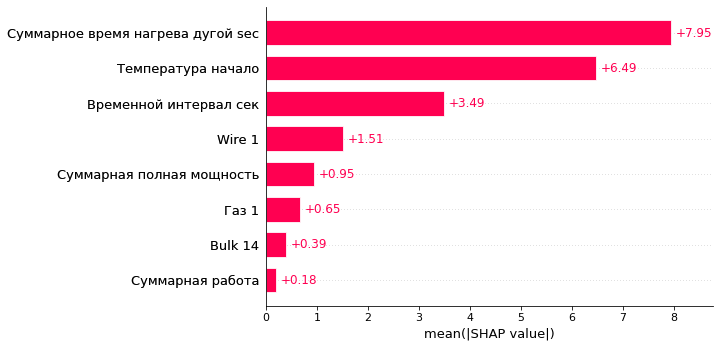

In [92]:
explainer = shap.LinearExplainer(model, X_test_)
shap_values = explainer(X_test_)
shap.plots.bar(shap_values, max_display=17) 

Итоги:
 - El gráfico de la importancia global de las características para el mejor modelo muestra que las tres más relevantes son:
    - Tiempo total de calentamiento por arco, Temperatura inicial y Tiempo de medición entre la primera y la última temperatura en segundos.(Суммарное время нагрева дугой, Начальная температура и Время замера между первой и последней температурами в секундах).
 - Esto se correlaciona con los datos del mapa de calor que refleja la correlación lineal entre características (las tres principales):
    - Wire 1, Temperatura inicial, Tiempo total de calentamiento por arco. (Wire 1, Начальная температура, Суммарное время нагрева дугой)
 - Esto también se correlaciona con los datos del mapa de calor que refleja la correlación no lineal entre características (las más relevantes):
    - Potencia total, Wire 1, Temperatura inicial, Tiempo de medición entre la primera y la última temperatura en segundos.(Полная мощность, Wire 1, Начальная температура, Время замера между первой и последней температурами в секундах).
 - Cómo exactamente estos parámetros influyen en la variable objetivo en el proceso productivo se puede discutir con los ingenieros.

### Conclusión final

En la conclusión final se describen los pasos clave con sus explicaciones; se proporciona una descripción completa del mejor modelo junto con el valor de la métrica; se indica que el objetivo ha sido alcanzado.

El proyecto consta de 11 capítulos:

 - 1. Descripción del proyecto – en este capítulo se describen los objetivos del cliente y del proyecto, los datos disponibles y los requisitos del cliente.

 - 2. Carga de datos – se cargaron las bibliotecas, módulos y los datos.

 - 3. Análisis exploratorio de cada documento – se realizó un análisis de los documentos para identificar anomalías de producción, verificar el tipo correcto de datos y los valores faltantes. Se llevó a cabo una revisión detallada de cada documento.
 - 4. Preprocesamiento de datos – en este capítulo se efectuó la eliminación de anomalías de producción (acordadas con el cliente), la eliminación de claves con una sola medición de temperatura (información no útil para la modelización), la eliminación de temperaturas intermedias en un lote (para evitar fugas de información), el tratamiento de valores faltantes en los materiales suministrados y añadidos, así como la agregación de parámetros por lotes (el lote es la unidad de modelización).
 - 5. Adición de características – se calcularon magnitudes físicas como la potencia total y el trabaj (oполная мощность и работа), así como magnitudes temporales: el tiempo de calentamiento por arco y el tiempo entre las mediciones de la temperatura inicial y final (время нагрева дуги, время между замерами начальной и конечной температур). La característica número de iteraciones (количество итераций) был рассчитан в главе 4 (в подразделе Удаление промежуточных температур в партии, перед удалением промежуточных температур). fue calculada en el capítulo 4 (en el subapartado Eliminación de temperaturas intermedias en el lote, antes de la eliminación de dichas temperaturas). Estas características no constituyen una fuga de información, ya que fueron definidas en el plan elaborado antes del inicio de la investigación.
 - 6. A continuación, se unieron los datos siguiendo el principio de conservar únicamente la información que estuviera presente en todos los documentos.

 - 7. Se realizó un análisis exploratorio de los datos combinados: se construyeron histogramas y diagramas de caja (boxplots) en una misma escala, se calcularon las características estadísticas. Se evaluaron las distribuciones y los posibles valores atípicos.
 - 8. Se realizó un análisis de correlación de los datos (se construyeron mapas de calor de la correlación lineal mediante el método de Pearson y de la correlación no lineal Phi). Se eliminó una de las variables en los pares multicolineales.
 - 9. División en conjuntos de entrenamiento y prueba con una proporción de 75/25; en adelante se utiliza en todo momento el Random State especificado por el cliente.
 - 10. El entrenamiento y la selección del mejor modelo se realizaron dentro de un pipeline. Se probaron diferentes tipos de escalado de datos y se entrenaron dos modelos: DecisionTreeClassifier() y LinearRegression(). Para el modelo DecisionTreeClassifier() se ajustaron los hiperparámetros "models__max_depth" y "models__max_features". Se utilizó GridSearchCV, que evaluó todas las combinaciones posibles. El Dummy Regressor se empleó como modelo base en el pipeline. GridSearchCV no seleccionó el modelo base, por lo tanto el mejor modelo superó la prueba de adecuación.

 - DESCRIPCIÓN COMPLETA DEL MEJOR MODELO – El mejor modelo fue LinearRegression(). Su métrica en validación cruzada: 6.2414663010830775. En el conjunto de prueba: MAE = 6.2489267146799765, R² = 0.465787773978964. Según el requisito del cliente, la métrica MAE en el conjunto de prueba debía ser ≤ 6.8. Por lo tanto, el objetivo fue alcanzado, ya que el mejor modelo obtuvo un MAE = 6.2.
 - 11. Prueba del mejor modelo – en este capítulo se evaluó el mejor modelo en el conjunto de prueba. Además de la métrica MAE, el cliente solicitó calcular la métrica R². Aunque el valor de R² fue relativamente bajo (0.46), en el gráfico se observa que la causa se debe únicamente a dos valores atípicos (predicciones poco precisas). En general, el modelo predijo correctamente casi todos los valores. Asimismo, en este capítulo se realizó el análisis de la importancia de las características. Características más importantes: el tiempo total de calentamiento por arco, la temperatura inicial y el tiempo de medición entre la primera y la última temperatura en segundos. (Суммарное время нагрева дугой, Начальная температура и Время замера между первой и последней температурами в секундах). Esto coincide con los mapas de calor de correlación y con la lógica general del proceso productivo.
 
